# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as psqf
import pyspark.sql.types as psqt
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, max, min, lit, when, col, count, countDistinct , avg
from pyspark.sql.types import *

In [221]:
from sklearn.metrics import roc_curve, auc
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes ,LogisticRegression, RandomForestClassifier, DecisionTreeClassifier ,GBTClassifier
from pyspark.mllib.tree import DecisionTree
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import seaborn as sns

In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify capstone project") \
    .getOrCreate()

In [5]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'sparkify capstone project'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1632328864135'),
 ('spark.driver.port', '33993'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '4b2e9af9d88b')]

In [6]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
path = "mini_sparkify_event_data.json"
sparkify_data = spark.read.json(path)

In [8]:
sparkify_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
sparkify_data.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [10]:
sparkify_data.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [11]:
sparkify_data.count()

286500

In [12]:
len(sparkify_data.columns)

18

In [13]:
null_vals = sparkify_data.select([psqf.count(psqf.when(psqf.isnull(n),n)).alias(n) for n in sparkify_data.columns])

In [14]:
null_vals.show() ## null values per colmun

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [15]:
null_vals.select("userId","page").show()

+------+----+
|userId|page|
+------+----+
|     0|   0|
+------+----+



In [16]:
sparkify_data.filter(sparkify_data["userId"] == "").show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [17]:

def sort_users(data, col):
    """
    Show the users in sorted order 
    """
    data.select([col]).dropDuplicates().sort(col).show()

In [18]:
sort_users(sparkify_data,"userId")

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



**userId** has empty values

In [19]:
sort_users(sparkify_data, 'length')

+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



**gender** has null values

In [20]:
sort_users(sparkify_data, 'itemInSession')

+-------------+
|itemInSession|
+-------------+
|            0|
|            1|
|            2|
|            3|
|            4|
|            5|
|            6|
|            7|
|            8|
|            9|
|           10|
|           11|
|           12|
|           13|
|           14|
|           15|
|           16|
|           17|
|           18|
|           19|
+-------------+
only showing top 20 rows



In [21]:
sort_users(sparkify_data, 'gender')

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



**gender** has null values

In [22]:
sort_users(sparkify_data, 'song')

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
|#2 For Prepared W...|
|                 #24|
|  #4 (Album Version)|
|                 #40|
|                   $|
|       $1000 Wedding|
|$87 And A Guilty ...|
|                $in$|
|       $timulus Plan|
|              & Down|
+--------------------+
only showing top 20 rows



**song** has null values

In [23]:
sort_users(sparkify_data, 'firstName')

+----------+
| firstName|
+----------+
|      null|
|  Adelaida|
|    Adrian|
|   Adriana|
|    Adriel|
|   Ainsley|
|      Alex|
| Alexander|
|Alexandria|
|     Alexi|
|    Alyssa|
|   Alyssia|
| Amberlynn|
|    Andrew|
|     Angel|
|     Anika|
|      Anna|
| Annabella|
|  Antonina|
|   Antonio|
+----------+
only showing top 20 rows



**firstName** has null values

In [24]:
sort_users(sparkify_data, 'lastName')

+---------+
| lastName|
+---------+
|     null|
|    Adams|
|  Aguilar|
|Alexander|
|    Allen|
| Atkinson|
|   Bailey|
|    Baker|
|     Ball|
|   Barnes|
|  Barnett|
|     Beck|
|  Bennett|
|     Bird|
|    Boone|
|  Bradley|
|   Brooks|
|    Brown|
|  Burgess|
|  Cabrera|
+---------+
only showing top 20 rows



**lastName** has null values

In [25]:
sort_users(sparkify_data, 'artist')

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
+--------------------+
only showing top 20 rows



**artist** has null values

In [26]:
sort_users(sparkify_data, 'page')

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [27]:
sort_users(sparkify_data, 'userAgent')

+--------------------+
|           userAgent|
+--------------------+
|                null|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



**userAgent** has null values

In [28]:
sort_users(sparkify_data, 'location')


+--------------------+
|            location|
+--------------------+
|                null|
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|        Billings, MT|
|Birmingham-Hoover...|
|Boston-Cambridge-...|
|         Boulder, CO|
|         Bozeman, MT|
|Bridgeport-Stamfo...|
|Buffalo-Cheektowa...|
|Charlotte-Concord...|
|Chicago-Napervill...|
+--------------------+
only showing top 20 rows



**location** has null values

In [29]:
sort_users(sparkify_data, 'auth')

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [30]:
sort_users(sparkify_data,'registration')

+-------------+
| registration|
+-------------+
|         null|
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1529027541000|
|1529252604000|
|1529643103000|
|1529934689000|
|1530306321000|
|1530333492000|
|1530514394000|
|1530674962000|
|1530763799000|
|1530789251000|
|1531281160000|
|1531350022000|
+-------------+
only showing top 20 rows



**registration** has null values

In [31]:
sort_users(sparkify_data, 'status')

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [32]:
sort_users(sparkify_data,'level')

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [33]:
sort_users(sparkify_data, 'ts')

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
|1538352678000|
|1538352886000|
|1538352899000|
|1538352905000|
|1538353084000|
|1538353146000|
|1538353150000|
|1538353218000|
|1538353375000|
|1538353376000|
|1538353441000|
|1538353576000|
|1538353668000|
|1538353687000|
|1538353744000|
+-------------+
only showing top 20 rows



In [34]:
sort_users(sparkify_data, 'sessionId')

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [35]:
sort_users(sparkify_data, 'method')

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



## Mention all columns has nulls, or an empty values :
- userId 
- userAgent 
- location 
- artist
- firstName 
- lastName 
- gender 
- length
- registration
- song

### Clean userId column 

remove all empty values for the userId and check again

In [36]:
sparkify_data_v1 = sparkify_data.filter(sparkify_data["userId"] != "")

In [37]:
sparkify_data.count()

286500

In [38]:
sparkify_data_v1.count()

278154

In [39]:
print(sparkify_data.count() - sparkify_data_v1.count() , " empty values removed")

8346  empty values removed


In [40]:
sort_users(sparkify_data_v1,"userId")

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



Ok, userId is clean now , will check the other column which has null values

In [41]:
sort_users(sparkify_data_v1,"userAgent")

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [42]:
sort_users(sparkify_data_v1,"location")

+--------------------+
|            location|
+--------------------+
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|        Billings, MT|
|Birmingham-Hoover...|
|Boston-Cambridge-...|
|         Boulder, CO|
|         Bozeman, MT|
|Bridgeport-Stamfo...|
|Buffalo-Cheektowa...|
|Charlotte-Concord...|
|Chicago-Napervill...|
|Cincinnati, OH-KY-IN|
+--------------------+
only showing top 20 rows



In [43]:
sort_users(sparkify_data_v1,"artist")

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
+--------------------+
only showing top 20 rows



**artist** column still has null values

In [44]:
sort_users(sparkify_data_v1,"firstName")

+----------+
| firstName|
+----------+
|  Adelaida|
|    Adrian|
|   Adriana|
|    Adriel|
|   Ainsley|
|      Alex|
| Alexander|
|Alexandria|
|     Alexi|
|    Alyssa|
|   Alyssia|
| Amberlynn|
|    Andrew|
|     Angel|
|     Anika|
|      Anna|
| Annabella|
|  Antonina|
|   Antonio|
|      Aron|
+----------+
only showing top 20 rows



In [45]:
sort_users(sparkify_data_v1,"lastName")

+---------+
| lastName|
+---------+
|    Adams|
|  Aguilar|
|Alexander|
|    Allen|
| Atkinson|
|   Bailey|
|    Baker|
|     Ball|
|   Barnes|
|  Barnett|
|     Beck|
|  Bennett|
|     Bird|
|    Boone|
|  Bradley|
|   Brooks|
|    Brown|
|  Burgess|
|  Cabrera|
| Calderon|
+---------+
only showing top 20 rows



In [46]:
sort_users(sparkify_data_v1,"gender")

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [47]:
sort_users(sparkify_data_v1,"length")

+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



**legnth** has null values

In [48]:
sort_users(sparkify_data_v1,"registration")

+-------------+
| registration|
+-------------+
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1529027541000|
|1529252604000|
|1529643103000|
|1529934689000|
|1530306321000|
|1530333492000|
|1530514394000|
|1530674962000|
|1530763799000|
|1530789251000|
|1531281160000|
|1531350022000|
|1531679695000|
+-------------+
only showing top 20 rows



In [49]:
sort_users(sparkify_data_v1,"song")

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
|#2 For Prepared W...|
|                 #24|
|  #4 (Album Version)|
|                 #40|
|                   $|
|       $1000 Wedding|
|$87 And A Guilty ...|
|                $in$|
|       $timulus Plan|
|              & Down|
+--------------------+
only showing top 20 rows



**song** has null values

### Currently song,legnth and artist columns still have null values

In [50]:
sparkify_data_v2 = sparkify_data_v1.filter(sparkify_data_v1["song"] != "null")

In [51]:
sort_users(sparkify_data_v2,"song")

+--------------------+
|                song|
+--------------------+
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
|#2 For Prepared W...|
|                 #24|
|  #4 (Album Version)|
|                 #40|
|                   $|
|       $1000 Wedding|
|$87 And A Guilty ...|
|                $in$|
|       $timulus Plan|
|              & Down|
|&And The Battle B...|
+--------------------+
only showing top 20 rows



In [52]:
sort_users(sparkify_data_v2,"artist")

+--------------------+
|              artist|
+--------------------+
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
+--------------------+
only showing top 20 rows



In [53]:
sort_users(sparkify_data_v2,"length")

+--------+
|  length|
+--------+
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
|12.43383|
+--------+
only showing top 20 rows



In [54]:
sparkify_data_v2.count()

228108

In [55]:
sparkify_data_v1.count()

278154

In [56]:
sparkify_data.count()

286500

# Now the data is totally clean

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [57]:
level_counts= sparkify_data_v1.groupby('level').agg({'level':'count'}).withColumnRenamed("count(level)", "level_count")
level_counts.show()

+-----+-----------+
|level|level_count|
+-----+-----------+
| free|      55721|
| paid|     222433|
+-----+-----------+



In [58]:
sparkify_data_v1.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [123]:
sparkify_data_v2.select("page").distinct().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



In [60]:
page_counts= sparkify_data_v1.groupby('page').agg({'page':'count'}).withColumnRenamed("count(page)", "page_count")

In [61]:
page_counts.show()

+--------------------+----------+
|                page|page_count|
+--------------------+----------+
|              Cancel|        52|
|    Submit Downgrade|        63|
|         Thumbs Down|      2546|
|                Home|     10082|
|           Downgrade|      2055|
|         Roll Advert|      3933|
|              Logout|      3226|
|       Save Settings|       310|
|Cancellation Conf...|        52|
|               About|       495|
|            Settings|      1514|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|            NextSong|    228108|
|           Thumbs Up|     12551|
|                Help|      1454|
|             Upgrade|       499|
|               Error|       252|
|      Submit Upgrade|       159|
+--------------------+----------+



In [62]:
churn = sparkify_data_v1.groupby('userId').agg(psqf.collect_list('page').alias('pages'))

In [63]:
# define 1 as churned, 0 otherwise
churn_v1 = psqf.udf(lambda x: 1 if 'Cancel' in set(x) else 0)
churn = churn.withColumn("label", churn_v1(churn.pages)).drop('pages')

In [64]:
churn.columns

['userId', 'label']

In [65]:
churn.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



### Churned VS Non Churned

**we defined churn, let's perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned.**

In [66]:
label_filter = churn.join(sparkify_data_v1,"userId")

In [67]:
label_filter.filter(psqf.col('page').isin(["Cancel", "Cancellation Confirmation"])).select('userId', 'page', 'label').show(3)

+------+--------------------+-----+
|userId|                page|label|
+------+--------------------+-----+
|   125|              Cancel|    1|
|   125|Cancellation Conf...|    1|
|    51|              Cancel|    1|
+------+--------------------+-----+
only showing top 3 rows



In [68]:
### how many users churned and non-churned ?

In [69]:
churn_count = label_filter.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    0|233290|
|    1| 44864|
+-----+------+



In [70]:
### How many songs played by churned and non churned users ?

In [71]:
songs_play = label_filter.where(psqf.col('song')!='null').groupby("label").agg(psqf.count(psqf.col('song')).alias('songs_play'))

In [72]:
songs_play.show(5)

+-----+----------+
|label|songs_play|
+-----+----------+
|    0|    191714|
|    1|     36394|
+-----+----------+



**As we see there are 191714 songs played for non-churned user and 36394 for churned users**

In [73]:
### How many songs liked by churned and non churned users ?

In [74]:
songs_liked_by_users = label_filter.where((psqf.col('page')=='Thumbs Up')).\
groupby("label").\
agg(psqf.count(psqf.col('page')).\
    alias('songs_liked_count'))

In [75]:
songs_liked_by_users.show(5, False)

+-----+-----------------+
|label|songs_liked_count|
+-----+-----------------+
|0    |10692            |
|1    |1859             |
+-----+-----------------+



**As we see there are 10692 songs liked for non-churned users and 1859 songs liked for churned users**

In [76]:
df_to_plot = label_filter.groupby('userId', 'level', 'label').count()
df_to_plot_pandas  = df_to_plot.select("userId", "level", 'label').toPandas()

### Plotting

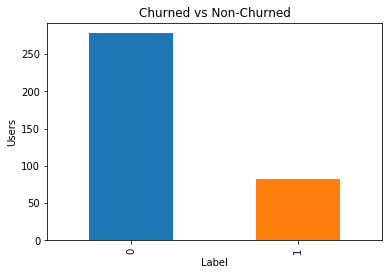

In [77]:
df_to_plot_pandas.label.value_counts().plot(kind='bar');
plt.ylabel('Users')
plt.xlabel('Label')
plt.title('Churned vs Non-Churned');

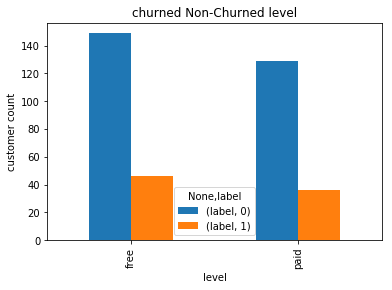

In [78]:
df_to_plot_pandas[['level', 'label']].groupby(['level', 'label']).agg({'label':'count'}).unstack().plot(kind='bar');
plt.title('churned Non-Churned level')
plt.ylabel('customer count');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [79]:
songs_played_count = sparkify_data_v1.filter("page == 'NextSong'").groupBy("userId").count()
songs_played_count = songs_played_count.withColumnRenamed('count', 'songs_played_counter')
songs_played_count.show()

+------+--------------------+
|userId|songs_played_counter|
+------+--------------------+
|100010|                 275|
|200002|                 387|
|   125|                   8|
|    51|                2111|
|   124|                4079|
|     7|                 150|
|    54|                2841|
|    15|                1914|
|   155|                 820|
|   132|                1928|
|   154|                  84|
|100014|                 257|
|   101|                1797|
|    11|                 647|
|   138|                2070|
|300017|                3632|
|    29|                3028|
|    69|                1125|
|100021|                 230|
|    42|                3573|
+------+--------------------+
only showing top 20 rows



In [80]:
session_length = sparkify_data_v1.select(['userId', 'length']).distinct().groupBy("userId") \
.agg(avg("length").alias("session_length"))

In [81]:
session_length.show(5)

+------+------------------+
|userId|    session_length|
+------+------------------+
|100010|243.28376220149258|
|200002| 243.8535182037533|
|   125|261.13913750000006|
|   124| 250.7709492796006|
|    51|247.92487476446036|
+------+------------------+
only showing top 5 rows



In [82]:
new_features = songs_played_count.join(session_length.select(['userId','session_length']),on = 'userId', how = 'inner')
new_features.show()

+------+--------------------+------------------+
|userId|songs_played_counter|    session_length|
+------+--------------------+------------------+
|100010|                 275|243.28376220149258|
|200002|                 387| 243.8535182037533|
|   125|                   8|261.13913750000006|
|   124|                4079| 250.7709492796006|
|    51|                2111|247.92487476446036|
|     7|                 150| 251.1926630405405|
|    15|                1914|251.10429575776783|
|    54|                2841|  251.978400607917|
|   155|                 820|240.49622712737127|
|100014|                 257| 261.8860570661157|
|   132|                1928|251.74449363344056|
|   154|                  84|247.27114390243895|
|   101|                1797|248.88575961643838|
|    11|                 647| 246.2084100000001|
|   138|                2070|249.05871161486903|
|300017|                3632| 249.7192652406623|
|100021|                 230|250.64712642857143|
|    29|            

In [83]:
songs_added_to_playlist = sparkify_data_v1.where(sparkify_data_v1.page=="Add to Playlist").groupby("userId").count()
songs_added_to_playlist = songs_added_to_playlist.withColumnRenamed('count', 'songs_added_to_playlist')
songs_added_to_playlist.show()

+------+-----------------------+
|userId|songs_added_to_playlist|
+------+-----------------------+
|100010|                      7|
|200002|                      8|
|    51|                     52|
|   124|                    118|
|     7|                      5|
|    15|                     59|
|    54|                     72|
|   155|                     24|
|   132|                     38|
|   154|                      1|
|100014|                      7|
|   101|                     61|
|    11|                     20|
|   138|                     67|
|300017|                    113|
|    29|                     89|
|    69|                     33|
|100021|                      7|
|    42|                    104|
|   112|                      7|
+------+-----------------------+
only showing top 20 rows



In [84]:
new_features = new_features.join(songs_added_to_playlist.select(['userId','songs_added_to_playlist']),on = 'userId', how = 'inner')
new_features.show()

+------+--------------------+------------------+-----------------------+
|userId|songs_played_counter|    session_length|songs_added_to_playlist|
+------+--------------------+------------------+-----------------------+
|100010|                 275|243.28376220149258|                      7|
|200002|                 387| 243.8535182037533|                      8|
|   124|                4079| 250.7709492796006|                    118|
|    51|                2111|247.92487476446036|                     52|
|     7|                 150| 251.1926630405405|                      5|
|    15|                1914|251.10429575776783|                     59|
|    54|                2841|  251.978400607917|                     72|
|   155|                 820|240.49622712737127|                     24|
|100014|                 257| 261.8860570661157|                      7|
|   132|                1928|251.74449363344056|                     38|
|   154|                  84|247.27114390243895|   

In [128]:
## Like Counts Feature
like_counts = sparkify_data_v1.where(sparkify_data_v1.page=="Thumbs Up").groupby("userId").count()
like_counts = like_counts.withColumnRenamed('count', 'like_counts')
new_features = new_features.join(like_counts.select(['userId','like_counts']),on = 'userId', how = 'inner')

In [129]:
## disLike Counts Feature
dislike_counts = sparkify_data_v1.where(sparkify_data_v1.page=="Thumbs Down").groupby("userId").count()
dislike_counts = dislike_counts.withColumnRenamed('count', 'dislike_counts')
new_features = new_features.join(dislike_counts.select(['userId','dislike_counts']),on = 'userId', how = 'inner')

In [130]:
new_features.show()

+------+--------------------+------------------+-----------------------+-----------+--------------+
|userId|songs_played_counter|    session_length|songs_added_to_playlist|like_counts|dislike_counts|
+------+--------------------+------------------+-----------------------+-----------+--------------+
|100010|                 275|243.28376220149258|                      7|         17|             5|
|200002|                 387| 243.8535182037533|                      8|         21|             6|
|   124|                4079| 250.7709492796006|                    118|        171|            41|
|    51|                2111|247.92487476446036|                     52|        100|            21|
|     7|                 150| 251.1926630405405|                      5|          7|             1|
|    15|                1914|251.10429575776783|                     59|         81|            14|
|    54|                2841|  251.978400607917|                     72|        163|            29|


In [132]:
## songs played per session
songs_played_per_session = sparkify_data_v1.where(sparkify_data_v1.page=="NextSong").groupby("userId", "sessionId").count()
songs_played_per_session = songs_played_per_session.groupby("userId").agg(avg(songs_played_per_session["count"]).alias("songs_played_per_session"))

In [133]:
new_features = new_features.join(songs_played_per_session.select(['userId','songs_played_per_session']),on = 'userId', how = 'inner')
new_features.show()

+------+--------------------+------------------+-----------------------+-----------+--------------+------------------------+
|userId|songs_played_counter|    session_length|songs_added_to_playlist|like_counts|dislike_counts|songs_played_per_session|
+------+--------------------+------------------+-----------------------+-----------+--------------+------------------------+
|100010|                 275|243.28376220149258|                      7|         17|             5|      39.285714285714285|
|200002|                 387| 243.8535182037533|                      8|         21|             6|                    64.5|
|   124|                4079| 250.7709492796006|                    118|        171|            41|      145.67857142857142|
|    51|                2111|247.92487476446036|                     52|        100|            21|                   211.1|
|     7|                 150| 251.1926630405405|                      5|          7|             1|      21.428571428571427|


In [134]:
## create churn flag column 
users_churned = sparkify_data_v1.where(sparkify_data_v1.auth=="Cancelled").select("userId").distinct()
#creating a list of users who churned
churned_list = [(row['userId']) for row in users_churned.collect()]
#assigning 1 to the event of churn, 0 otherwise.
sparkify_data_v1_with_churn = sparkify_data_v1.withColumn("churned", when(col("userId").isin(churned_list),1).otherwise(0))

In [135]:
sparkify_data_v1_with_churn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churned: integer (nullable = false)



In [136]:
churned_users_df = sparkify_data_v1_with_churn.select(['userId', 'churned']).distinct()
churned_users_df.show()

+------+-------+
|userId|churned|
+------+-------+
|    19|      0|
|100005|      1|
|200007|      0|
|300007|      1|
|    50|      0|
|200002|      0|
|    30|      0|
|     8|      0|
|100011|      1|
|100012|      1|
|     4|      0|
|    65|      0|
|   101|      1|
|    13|      0|
|   153|      0|
|    42|      0|
|100014|      1|
|    94|      0|
|    62|      0|
|   114|      0|
+------+-------+
only showing top 20 rows



In [137]:
new_features_with_churn = new_features.join(churned_users_df, on ='userId', how ='inner')
new_features_with_churn.show()

+------+--------------------+------------------+-----------------------+-----------+--------------+------------------------+-------+
|userId|songs_played_counter|    session_length|songs_added_to_playlist|like_counts|dislike_counts|songs_played_per_session|churned|
+------+--------------------+------------------+-----------------------+-----------+--------------+------------------------+-------+
|100010|                 275|243.28376220149258|                      7|         17|             5|      39.285714285714285|      0|
|200002|                 387| 243.8535182037533|                      8|         21|             6|                    64.5|      0|
|   124|                4079| 250.7709492796006|                    118|        171|            41|      145.67857142857142|      0|
|    51|                2111|247.92487476446036|                     52|        100|            21|                   211.1|      1|
|     7|                 150| 251.1926630405405|                     

In [142]:
## convert values to float
def convert_to_float(dataset,col_names,new_type):
    for col_name in col_names:
        dataset = dataset.withColumn(col_name,dataset[col_name].cast(new_type))
    return dataset

In [143]:
new_columns = new_features_with_churn.columns[1:]

In [144]:
new_features_with_churn_V1 = convert_to_float(new_features_with_churn,new_columns,FloatType())

In [145]:
new_features_with_churn_V1.show()

+------+--------------------+--------------+-----------------------+-----------+--------------+------------------------+-------+
|userId|songs_played_counter|session_length|songs_added_to_playlist|like_counts|dislike_counts|songs_played_per_session|churned|
+------+--------------------+--------------+-----------------------+-----------+--------------+------------------------+-------+
|100010|               275.0|     243.28377|                    7.0|       17.0|           5.0|               39.285713|    0.0|
|200002|               387.0|     243.85352|                    8.0|       21.0|           6.0|                    64.5|    0.0|
|   124|              4079.0|     250.77095|                  118.0|      171.0|          41.0|               145.67857|    0.0|
|    51|              2111.0|     247.92488|                   52.0|      100.0|          21.0|                   211.1|    1.0|
|     7|               150.0|     251.19266|                    5.0|        7.0|           1.0|  

In [146]:
new_features_with_churn_V1.printSchema()

root
 |-- userId: string (nullable = true)
 |-- songs_played_counter: float (nullable = false)
 |-- session_length: float (nullable = true)
 |-- songs_added_to_playlist: float (nullable = false)
 |-- like_counts: float (nullable = false)
 |-- dislike_counts: float (nullable = false)
 |-- songs_played_per_session: float (nullable = true)
 |-- churned: float (nullable = false)



In [148]:
columns_to_plot = new_features_with_churn_V1.columns[1:]
columns_to_plot_df = new_features_with_churn_V1.select(columns_to_plot).toPandas()

## Plot distributions of all features

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


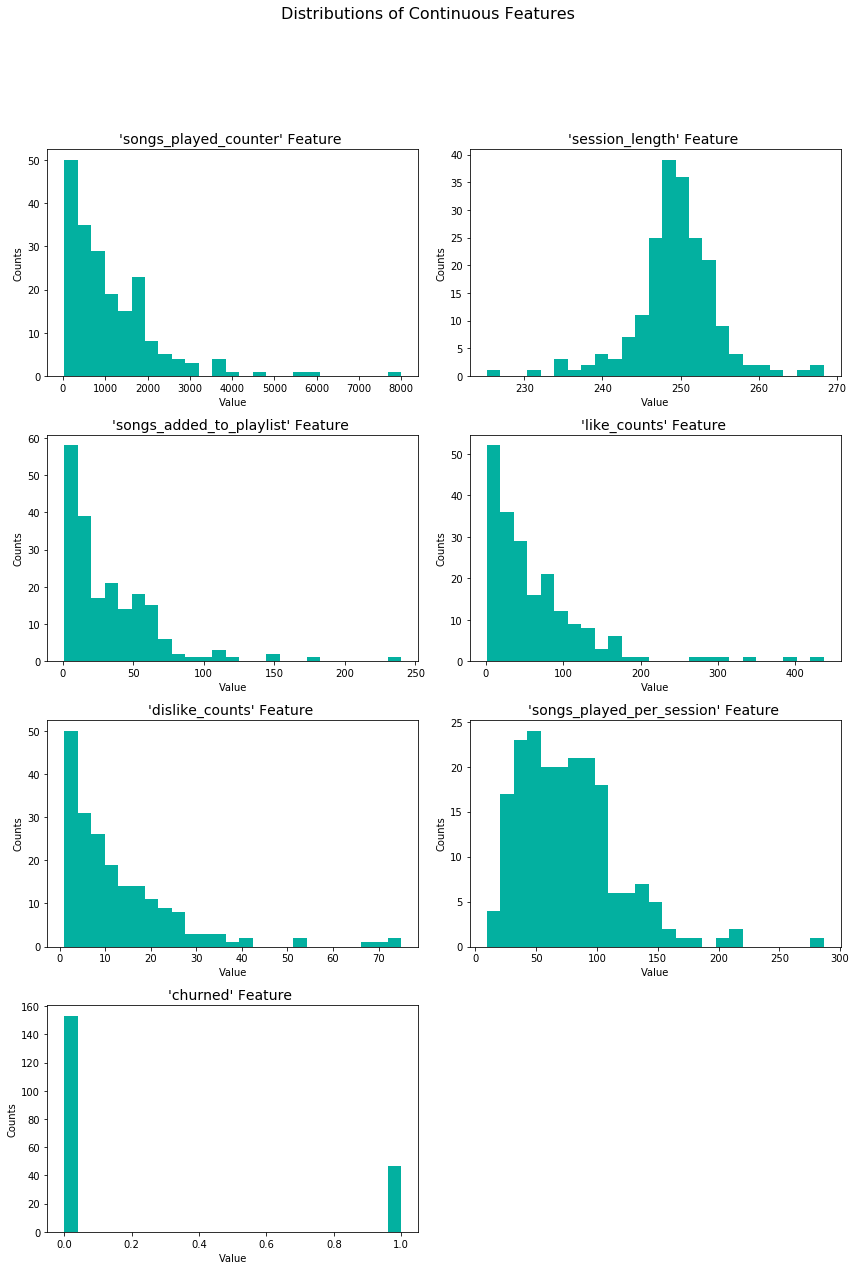

In [152]:
# Create a new figure
fig = plt.figure(figsize = (12,16));

# Skewed feature plotting
for i, feature in enumerate(columns_to_plot):
    ax = fig.add_subplot(4, 2, i+1)
    ax.hist(columns_to_plot_df[feature], bins = 25, color = '#03B0A0')
    ax.set_title("'%s' Feature "%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Counts")

# Plot aesthetics
fig.suptitle("Distributions of Continuous Features",fontsize = 16, y = 1.1)
fig.tight_layout()
fig.show()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [174]:
features_engineered = ["songs_played_counter","session_length","songs_added_to_playlist","like_counts",
                       "dislike_counts","songs_played_per_session"]

In [175]:
#### Feature Transform

In [176]:
#transform the data
assembler = VectorAssembler(inputCols=features_engineered, outputCol="features_vector")

In [177]:
features_transformed = assembler.transform(new_features_with_churn_V1)

In [178]:
scaler = StandardScaler(inputCol="features_vector", outputCol="scaledFeatures",withStd=True, withMean=False)

In [179]:
scaler_model = scaler.fit(features_transformed)

In [180]:
scaled_df = scaler_model.transform(features_transformed)

In [181]:
scaled_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- songs_played_counter: float (nullable = false)
 |-- session_length: float (nullable = true)
 |-- songs_added_to_playlist: float (nullable = false)
 |-- like_counts: float (nullable = false)
 |-- dislike_counts: float (nullable = false)
 |-- songs_played_per_session: float (nullable = true)
 |-- churned: float (nullable = false)
 |-- features_vector: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



In [182]:
scaled_df.select(['features_vector', 'scaledFeatures']).show()

+--------------------+--------------------+
|     features_vector|      scaledFeatures|
+--------------------+--------------------+
|[275.0,243.283767...|[0.24625383230211...|
|[387.0,243.853515...|[0.34654630218515...|
|[4079.0,250.77095...|[3.65261593440120...|
|[2111.0,247.92488...|[1.89033396359915...|
|[150.0,251.192657...|[0.13432027216479...|
|[1914.0,251.10429...|[1.71392667282272...|
|[2841.0,251.97839...|[2.54402595480113...|
|[820.0,240.496231...|[0.73428415450085...|
|[257.0,261.886047...|[0.23013539964234...|
|[1928.0,251.74449...|[1.72646323155810...|
|[1797.0,248.88575...|[1.60915686053419...|
|[647.0,246.208404...|[0.57936810727079...|
|[2070.0,249.05871...|[1.85361975587411...|
|[3632.0,249.71926...|[3.25234152335013...|
|[230.0,250.647125...|[0.20595775065267...|
|[3028.0,251.21818...|[2.71147856076657...|
|[1125.0,253.56698...|[1.00740204123592...|
|[215.0,248.543365...|[0.19252572343619...|
|[3573.0,248.87731...|[3.19950888296531...|
|[377.0,251.707031...|[0.3375916

In [183]:
scaled_df.head(1)

[Row(userId='100010', songs_played_counter=275.0, session_length=243.2837677001953, songs_added_to_playlist=7.0, like_counts=17.0, dislike_counts=5.0, songs_played_per_session=39.28571319580078, churned=0.0, features_vector=DenseVector([275.0, 243.2838, 7.0, 17.0, 5.0, 39.2857]), scaledFeatures=DenseVector([0.2463, 45.1153, 0.211, 0.2552, 0.3781, 0.9502]))]

In [184]:
df_ready = scaled_df

In [185]:
df_ready.printSchema()

root
 |-- userId: string (nullable = true)
 |-- songs_played_counter: float (nullable = false)
 |-- session_length: float (nullable = true)
 |-- songs_added_to_playlist: float (nullable = false)
 |-- like_counts: float (nullable = false)
 |-- dislike_counts: float (nullable = false)
 |-- songs_played_per_session: float (nullable = true)
 |-- churned: float (nullable = false)
 |-- features_vector: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



In [186]:
df_ready.show(3)

+------+--------------------+--------------+-----------------------+-----------+--------------+------------------------+-------+--------------------+--------------------+
|userId|songs_played_counter|session_length|songs_added_to_playlist|like_counts|dislike_counts|songs_played_per_session|churned|     features_vector|      scaledFeatures|
+------+--------------------+--------------+-----------------------+-----------+--------------+------------------------+-------+--------------------+--------------------+
|100010|               275.0|     243.28377|                    7.0|       17.0|           5.0|               39.285713|    0.0|[275.0,243.283767...|[0.24625383230211...|
|200002|               387.0|     243.85352|                    8.0|       21.0|           6.0|                    64.5|    0.0|[387.0,243.853515...|[0.34654630218515...|
|   124|              4079.0|     250.77095|                  118.0|      171.0|          41.0|               145.67857|    0.0|[4079.0,250.77095

### Split the data into train and test

In [187]:
train , test = df_ready.randomSplit([0.8,0.2], seed = 42)

In [188]:
train.head(10)

[Row(userId='100010', songs_played_counter=275.0, session_length=243.2837677001953, songs_added_to_playlist=7.0, like_counts=17.0, dislike_counts=5.0, songs_played_per_session=39.28571319580078, churned=0.0, features_vector=DenseVector([275.0, 243.2838, 7.0, 17.0, 5.0, 39.2857]), scaledFeatures=DenseVector([0.2463, 45.1153, 0.211, 0.2552, 0.3781, 0.9502])),
 Row(userId='124', songs_played_counter=4079.0, session_length=250.7709503173828, songs_added_to_playlist=118.0, like_counts=171.0, dislike_counts=41.0, songs_played_per_session=145.67857360839844, churned=0.0, features_vector=DenseVector([4079.0, 250.771, 118.0, 171.0, 41.0, 145.6786]), scaledFeatures=DenseVector([3.6526, 46.5037, 3.5561, 2.5666, 3.1003, 3.5235])),
 Row(userId='7', songs_played_counter=150.0, session_length=251.19265747070312, songs_added_to_playlist=5.0, like_counts=7.0, dislike_counts=1.0, songs_played_per_session=21.428571701049805, churned=0.0, features_vector=DenseVector([150.0, 251.1927, 5.0, 7.0, 1.0, 21.428

In [189]:
test.head(10)

[Row(userId='200002', songs_played_counter=387.0, session_length=243.853515625, songs_added_to_playlist=8.0, like_counts=21.0, dislike_counts=6.0, songs_played_per_session=64.5, churned=0.0, features_vector=DenseVector([387.0, 243.8535, 8.0, 21.0, 6.0, 64.5]), scaledFeatures=DenseVector([0.3465, 45.2209, 0.2411, 0.3152, 0.4537, 1.56])),
 Row(userId='51', songs_played_counter=2111.0, session_length=247.9248809814453, songs_added_to_playlist=52.0, like_counts=100.0, dislike_counts=21.0, songs_played_per_session=211.10000610351562, churned=1.0, features_vector=DenseVector([2111.0, 247.9249, 52.0, 100.0, 21.0, 211.1]), scaledFeatures=DenseVector([1.8903, 45.9759, 1.5671, 1.501, 1.5879, 5.1058])),
 Row(userId='15', songs_played_counter=1914.0, session_length=251.1042938232422, songs_added_to_playlist=59.0, like_counts=81.0, dislike_counts=14.0, songs_played_per_session=136.7142791748047, churned=0.0, features_vector=DenseVector([1914.0, 251.1043, 59.0, 81.0, 14.0, 136.7143]), scaledFeatures

## Model Selection & Evaluation

**I will train 5 algorithms on the dataset and select the best model**

1. RandomForestClassifier
2. Naive Bayes classifier 
3. DecisionTreeClassifier
4. LogisticRegression
5. GradientBoostedTreeClassifier

In [190]:
import time

### Random Forest classifier 

In [300]:
rf = RandomForestClassifier(featuresCol = 'scaledFeatures', labelCol = 'churned')

In [301]:
start = time.time()
model_rf = rf.fit(train)
end = time.time()
print(f'Model is trained and spent {end - start} seconds')

Model is trained and spent 92.38722229003906 seconds


In [302]:
preds = model_rf.transform(test)
ROC_elevator_rf= BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churned', metricName='areaUnderROC')
ROC_rf = ROC_elevator_rf.evaluate(preds)
print("Area Under Curve: " + str(ROC_rf))
print("Test Error = %g" % (1.0 - ROC_rf))

Area Under Curve: 0.6
Test Error = 0.4


### Naive Bayes classifier 

In [239]:
nv = NaiveBayes(featuresCol = 'scaledFeatures', labelCol = 'churned')

In [240]:
start = time.time()
model_nv = nv.fit(train)
end = time.time()
print(f'Model is trained and spent {end - start}s')

Model is trained and spent 53.696372747421265s


In [241]:
preds = model_nv.transform(test)
ROC_elevator_nv= BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churned', metricName='areaUnderROC')
ROC_nv = ROC_elevator_nv.evaluate(preds)
print("Area Under Curve: " + str(ROC_nv))
print("Test Error = %g" % (1.0 - ROC_nv))

Area Under Curve: 0.5
Test Error = 0.5


### Decision Tree classifier 

In [242]:
ds = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'churned',maxDepth=7)

In [243]:
start = time.time()
model_ds = ds.fit(train)
end = time.time()
print(f'Model is trained and spent {end - start}s')

Model is trained and spent 84.65532064437866s


In [244]:
preds = model_ds.transform(test)
ROC_elevator_ds= BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churned', metricName='areaUnderROC')
ROC_ds = ROC_elevator_ds.evaluate(preds)
print("Area Under Curve: " + str(ROC_ds))
print("Test Error = %g" % (1.0 - ROC_ds))

Area Under Curve: 0.55
Test Error = 0.45


### Logistic Regression classifier 

In [256]:
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'churned')

In [257]:
start = time.time()
model_lr = lr.fit(train)
end = time.time()
print(f'Model is trained and spent {end - start}s')

Model is trained and spent 222.21597623825073s


In [258]:
preds = model_lr.transform(test)

In [259]:
ROC_elevator_lr= BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churned', metricName='areaUnderROC')
ROC_lr = ROC_elevator_lr.evaluate(preds)
print("Area Under Curve: " + str(ROC_lr))
print("Test Error = %g" % (1.0 - ROC_lr))

Area Under Curve: 0.5
Test Error = 0.5


### GradientBoostedTreeClassifier

In [253]:
gb = GBTClassifier(featuresCol = 'scaledFeatures', labelCol = 'churned')

In [254]:
start = time.time()
model_gb = gb.fit(train)
end = time.time()
print(f'Model is trained and spent {end - start}s')

Model is trained and spent 303.87891817092896s


In [255]:
preds = model_gb.transform(test)
ROC_elevator_gb= BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churned', metricName='areaUnderROC')
ROC_gb = ROC_elevator_gb.evaluate(preds)
print("Area Under Curve: " + str(ROC_gb))
print("Test Error = %g" % (1.0 - ROC_gb))

Area Under Curve: 0.6
Test Error = 0.4


## Model Tuning and Improve Performance

**I will use Random Forest and Gradient Boosted Tree to perform cross-validation**

In [260]:
train_cross_val = train.withColumnRenamed("churned", "label").withColumnRenamed("scaledFeatures", 'features')

In [261]:
test_cross_val= test.withColumnRenamed("churned", "label").withColumnRenamed("scaledFeatures", 'features')

In [304]:
numFolds = 3
rf_cv = RandomForestClassifier(maxBins=10)
evaluator = BinaryClassificationEvaluator()  
paramGrid = (ParamGridBuilder().addGrid(rf_cv.numTrees, [10, 15]).addGrid(rf_cv.maxDepth, [4, 10, 15]).build())

In [305]:
cross_validator = CrossValidator(estimator=rf_cv,estimatorParamMaps=paramGrid,evaluator=evaluator,numFolds=numFolds)

In [306]:
start = time.time()
model_rf_cv = cross_validator.fit(train_cross_val)
end = time.time()

In [307]:
print("Training took %s seconds. For Random Forest Cross Validation" % (end - start))

Training took 958.0781052112579 seconds. For Random Forest Cross Validation


In [308]:
def check_accuracy(model,test_data):
    '''
    Function : return accuracy and area under curve
    Arguments : model and test data
    returnns : accuracy and AUC
    '''
    print("Model is testing .........")
    preds = model.transform(test_data)
    
    evaluator_areaUnderROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
    ROC = evaluator_areaUnderROC.evaluate(preds)
    print("Test Area Under ROC: " + str(ROC))
    print("Test Error = %g" % (1.0 - ROC))
    
    return preds, ROC

In [309]:
check_accuracy(model_rf_cv,test_cross_val)

Model is testing .........
Test Area Under ROC: 0.6285714285714286
Test Error = 0.371429


(DataFrame[userId: string, songs_played_counter: float, session_length: float, songs_added_to_playlist: float, like_counts: float, dislike_counts: float, songs_played_per_session: float, label: float, features_vector: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double],
 0.6285714285714286)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

https://github.com/AhmadAbdElhameed/Data-Scientist-Nanodegree/blob/main/sparkify%20capstone%20project/README.md

#### Blog Post

https://am2958.medium.com/sparkify-capstone-project-2b9eb2bc4a76

#### References

- https://spark.apache.org/docs/latest/ml-classification-regression.html
- https://knowledge.udacity.com/questions/701396
- https://knowledge.udacity.com/questions/682588
- https://knowledge.udacity.com/questions/55247
- https://knowledge.udacity.com/questions/354600